In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
import numpy as np

In [2]:
df = pd.read_pickle('../results/results.pkl')

In [7]:
def get_rows(
    args_dict,
):
    idx = {}
    for key, value in args_dict.items():
        if value is None:
            idx[key] = np.ones_like(df[key], dtype=bool)
        else:
            idx[key] = df[key] == value
        
    run_idx = np.ones_like(df['test_loss'], dtype=bool)
    for key, value in idx.items():
        run_idx = run_idx & value
    
    # print(f"Selected {run_idx.sum()} runs!")
    
    run_df = df[run_idx].reset_index(drop=True)   
    return run_df

def get_loss(
    args_dict,
):
    run_df = get_rows(args_dict)

    rank_set = np.unique(run_df['rank'])
    seed_set = np.unique(run_df['seed'])
    test_loss, test_loss_mean, test_loss_std = {}, {}, {}
    
    for tune_bias in [0,1]:
        test_loss_mean[tune_bias], test_loss_std[tune_bias], test_loss[tune_bias] = {}, {}, {}
        group_df = run_df[run_df['tune_bias'] == tune_bias].reset_index(drop=True)        
        for rank in rank_set:
            rank_df = group_df[group_df['rank'] == rank].reset_index(drop=True)
            test_loss[tune_bias][rank], test_loss_mean[tune_bias][rank], test_loss_std[tune_bias][rank] = {}, {}, {}
            for seed in seed_set:
                seed_df = rank_df[rank_df['seed'] == seed].reset_index(drop=True)        
                min_loss_index = seed_df['val_loss'].idxmin()
                row_with_min_loss = seed_df.loc[min_loss_index]
                test_loss[tune_bias][rank][seed] = row_with_min_loss['test_loss']

        
            test_loss_mean[tune_bias][rank] = pd.Series(test_loss[tune_bias][rank]).median()
            test_loss_std[tune_bias][rank] = pd.Series(test_loss[tune_bias][rank]).std()
    return pd.DataFrame(test_loss_mean)

## FNN Approximation

In [8]:
activation = 'relu'
width = 16
exp = 'fnn'
init_mode = 'default'
target_depth = 1
frozen_depth = 2
fnn_results = {}

for pretrained in [0,1]:
    fnn_results[pretrained] = get_loss({
    'activation': activation,
    'target_depth': target_depth,
    'frozen_depth': frozen_depth,
    'init_mode': init_mode,
    'width': width,
    'exp': exp,
    'pretrained': pretrained
})
    

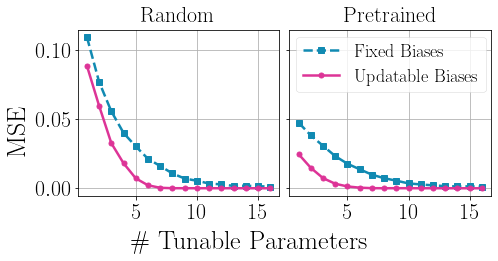

In [9]:
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend


sgd_marker, sgd_color, sgd_lt, sgd_ms = 's', '#118AB2', '--', 6
our_marker, our_color, our_lt, our_ms = 'o', '#DD3497', '-', 5
lw = 2.5

fig, ax = plt.subplots(nrows=1, ncols=2, sharey = True)
fig.subplots_adjust(left=0.16, bottom=.24, right=0.98, top=0.9, wspace=0.05, hspace = 0.3) #margin of the figure
fig.set_size_inches(7, 3.5) #exact size of the figure

for pretrained in [0,1]:
    fnn_results[pretrained][0].plot(ax = ax[pretrained], color = sgd_color, label = 'Fixed Biases', linestyle = sgd_lt, marker = sgd_marker, linewidth = lw, markersize = sgd_ms)
    fnn_results[pretrained][1].plot(ax = ax[pretrained], color = our_color, label = 'Updatable Biases', linestyle = our_lt, marker = our_marker, linewidth = lw, markersize = our_ms)
    ax[pretrained].grid(True)

ax[0].set_title('Random', size = 22, y = 1.01)
ax[1].set_title('Pretrained', size = 22, y = 1.01)

# ax[0].set_ylim(0,0.15)
ax[1].legend(fontsize=18, bbox_to_anchor=(1.02,1.01))
fig.supxlabel('\# Tunable Parameters', fontsize = 26)
fig.supylabel('MSE', fontsize = 26)
    
plt.savefig('../figures/lora_bitfit_approx.pdf')
# Show the plot
plt.show()
